# Temporal Convolutional Network

Implemented as in *An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling (2018)* https://arxiv.org/abs/1803.01271

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
%config IPCompleter.greedy=True

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datasets import Traffic, ECG5000, split_dataset
from models.tcn import TemporalConvNet

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import plot_forecasts, Evaluation

In [3]:
# CONTROLS
LOAD = False # whether to load or train model

# TEST

In [7]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [9]:
input_size = 84
output_size = 56
batch_size = 16
epochs = 10
lr = 0.001
log_interval = 1


channel_sizes = [128] * 3
kernel_size = 5
dropout = 0.25

model = TCN(input_size, output_size, channel_sizes, kernel_size=kernel_size, dropout=dropout)
optimizer = getattr(torch.optim, "Adam")(model.parameters(), lr=lr)

In [6]:
def train(epoch):
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            cur_loss = total_loss / log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0

def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
    return test_loss.item()

for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

NameError: name 'X_train' is not defined

# Dataset: ECG5000

In [15]:
# Parameters
window = 84
horizon = 56
batch_size = 10
epochs = 20
lr = 0.01
 
# Load data
ecg_train = ECG5000("./data/ECG5000/ECG5000_TRAIN.tsv", window, horizon)
ecg_test = ECG5000("./data/ECG5000/ECG5000_TEST.tsv", window, horizon)
ecg_train_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=True, drop_last=True)
ecg_test_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=False, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
    
# Train and save model OR load model from pickle
if not LOAD:    
    train_model(gru_net, optimizer, loss_fn, ecg_train_loader, epochs=epochs)
    
    with open('./saved_models/grudilate_ecg.pickle', 'wb') as handle:
        pickle.dump(gru_net, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/grudilate_ecg.pickle', 'rb') as handle:
        gru_net = pickle.load(handle)

# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(gru_net, ecg_test_loader)

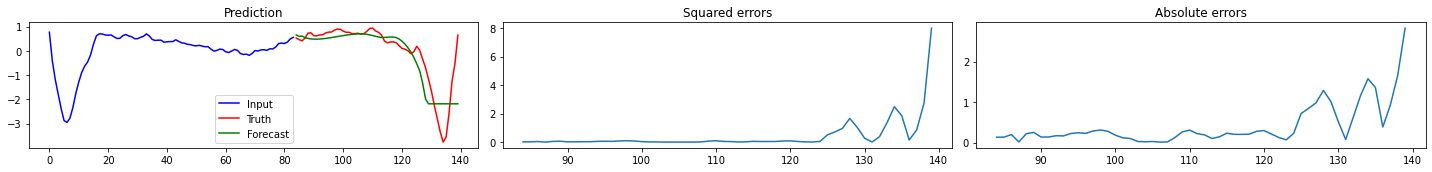

TDI: 0.14, TDM: 0.66 


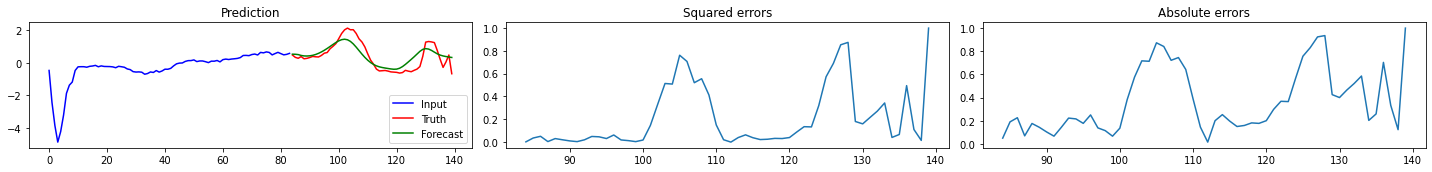

TDI: 0.09, TDM: -0.43 


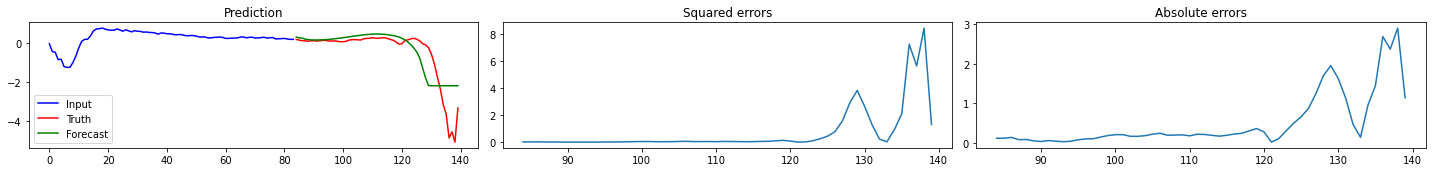

TDI: 0.17, TDM: -0.42 


In [16]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

Evaluation of method 'GRU' on dataset 'ECG5000', a total of 500 56-step forecasts.



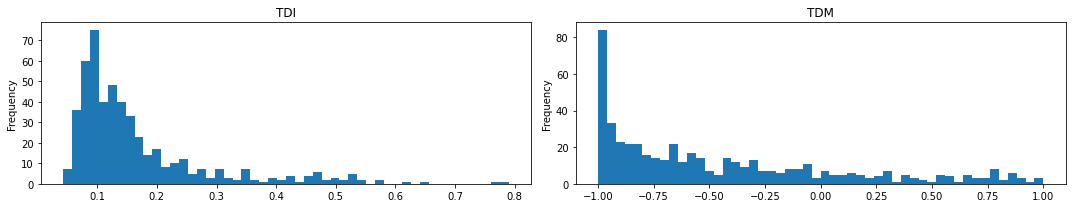

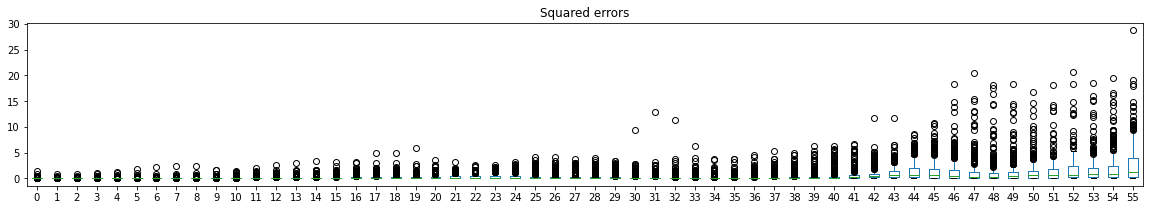

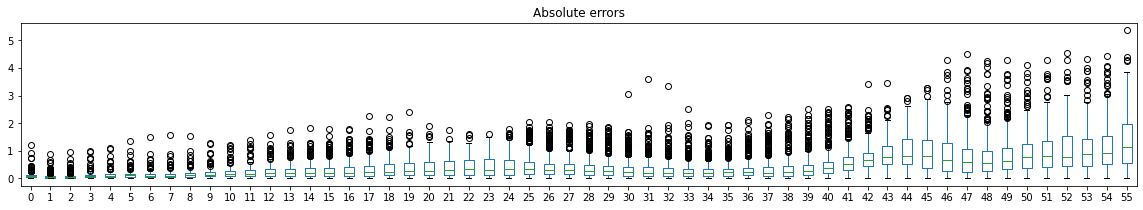

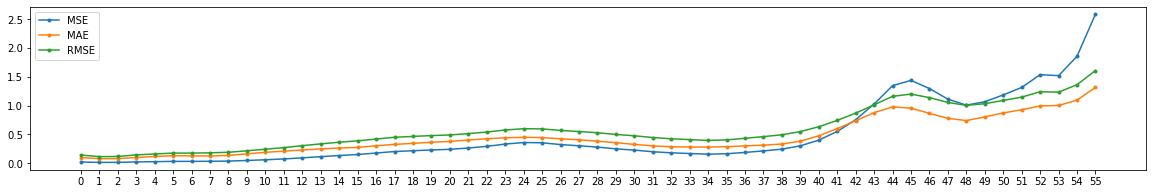

In [17]:
# Compute evaluation
res_ecg = Evaluation(y_test, yhat_test, "ECG5000", "GRU")
print(res_ecg)
res_ecg.plot()

# Dataset: Traffic

In [18]:
# Parameters
window = 24
horizon = 24
batch_size = 32
epochs = 20
lr = 0.01
 
# Load data
ds = Traffic("./data/mvdata/traffic.txt", 24, 24, usecol=0)
traffic_train, traffic_test = split_dataset(ds, 0.2)
traffic_train_loader = torch.utils.data.DataLoader(traffic_train, batch_size=batch_size, shuffle=True, drop_last=True)
traffic_test_loader = torch.utils.data.DataLoader(traffic_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Train and save model OR load model from pickle
if not LOAD:    
    train_model(gru_net, optimizer, loss_fn, traffic_train_loader, epochs=epochs)
    
    with open('./saved_models/grudilate_traffic.pickle', 'wb') as handle:
        pickle.dump(gru_net, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/grudilate_traffic.pickle', 'rb') as handle:
        gru_net = pickle.load(handle)

# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(gru_net, traffic_test_loader)

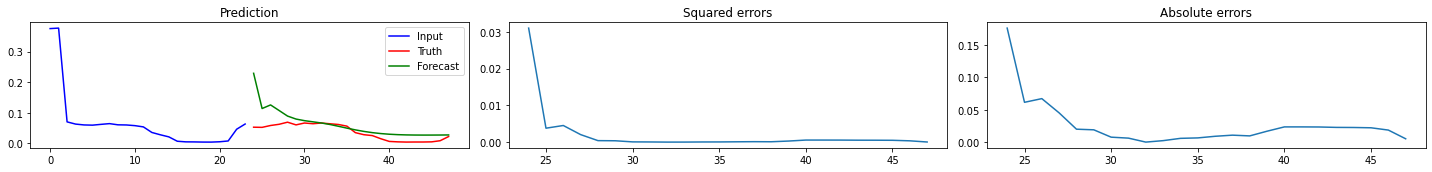

TDI: 0.12, TDM: 0.91 


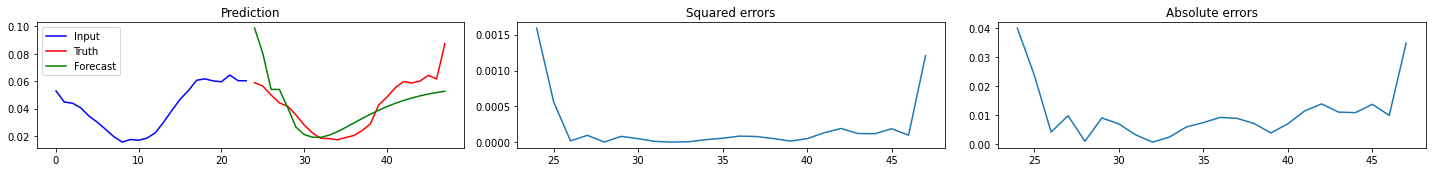

TDI: 0.16, TDM: 0.23 


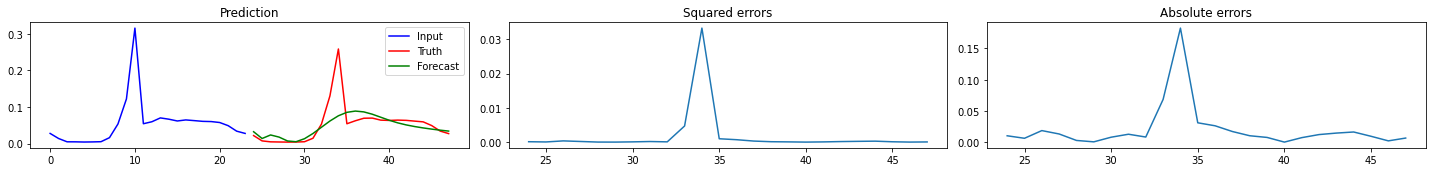

TDI: 0.13, TDM: 0.29 


In [19]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

Evaluation of method 'GRU' on dataset 'Traffic', a total of 3488 24-step forecasts.



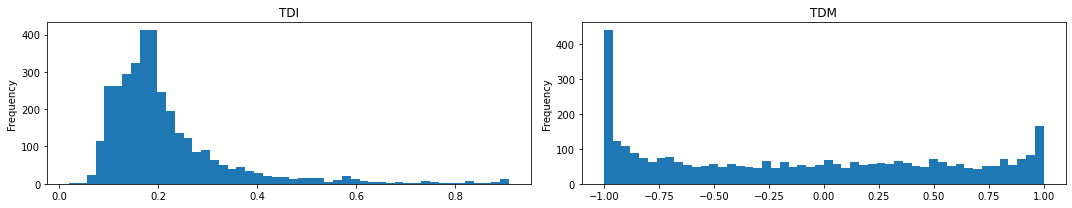

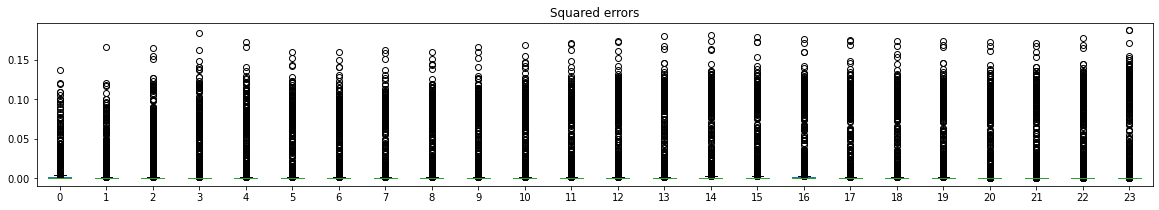

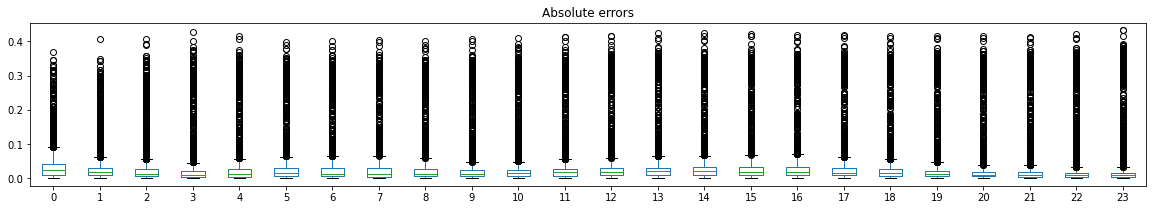

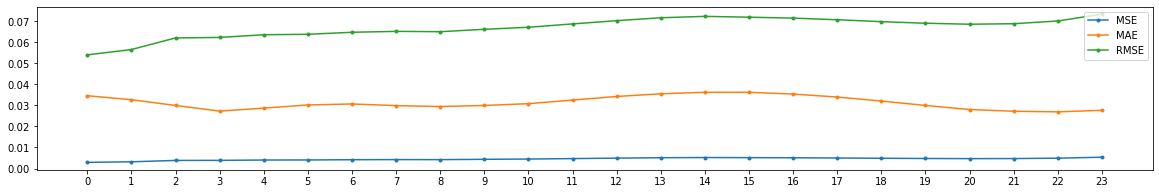

In [20]:
# Compute evaluation
res_traffic = Evaluation(y_test, yhat_test, "Traffic", "GRU")
print(res_traffic)
res_traffic.plot()